# Preparation part

### Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Imports

In [0]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import Dropout, Activation, BatchNormalization, Flatten
from keras.layers import Conv2D, LSTM
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, History
import os
import numpy as np
import pylab as plt
import pickle
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

import warnings
warnings.filterwarnings(action='once')

### General plotting settings / functions

In [0]:
plt.gray()

def show_plots(title):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

<Figure size 432x288 with 0 Axes>

### General constants / training settings

In [0]:
num_classes = 10
use_dropout = True
SAMPLES_PER_SIGN = 40
save_dir = os.path.join('/content/drive/My Drive/Course_work_SLR', 'saved_models')

# Work with data

### Load part of the data

In [0]:
# import Data class from My drive
!cp "/content/drive/My Drive/Course_work_SLR/src/Data.py" .
from Data import Data

In [0]:
with open('/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/hands_masked/masked_data_10.pkl', 'rb') as file:
    data = pickle.load(file)

# with open(f'/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/hands_masked/first_{num_classes}_masked.pkl', 'rb') as file:
#     (x_train, x_test, y_train, y_test) = pickle.load(file)

In [0]:
def prepare_data(data):
    x_train, x_test, y_train, y_test = data.x_train, data.x_test, data.y_train, data.y_test
    
    x_train = x_train.reshape(*x_train.shape, 1)
    x_test = x_test.reshape(*x_test.shape, 1)
    
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train, y_test

In [0]:
x_train, x_test, y_train, y_test = prepare_data(data)

### Overview

In [0]:
print("Train data shape:", x_train.shape)
print("Train samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])

Train data shape: (400, 10, 212, 380, 1)
Train samples: 400
Test samples: 100


# Work with models

## Model for 16 gestures

### Initialize model

In [0]:
small_model = Sequential()
small_model.add(TimeDistributed(Conv2D(filters=32,
                                         kernel_size=(5,5),
                                         activation='relu',
                                         input_shape=(10, 212, 380, 1))))
small_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
small_model.add(TimeDistributed(Dropout(0.25)))
small_model.add(TimeDistributed(Conv2D(filters=32,
                                         kernel_size=(3,3),
                                         activation='relu')))
small_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
small_model.add(TimeDistributed(Dropout(0.25)))

small_model.add(TimeDistributed(Flatten()))

small_model.add(LSTM(64, dropout=0.25))
small_model.add(Dropout(0.25))

small_model.add(Dense(256, activation='relu'))
small_model.add(Dense(num_classes, activation='softmax'))

small_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)

### Training

In [0]:
checkpoint = ModelCheckpoint(os.path.join(save_dir, 'small_model_weights.h5'),
                             monitor='categorical_accuracy',
                             verbose=1, save_best_only=True, mode='max')
history = History()
callbacks_list = [checkpoint, history]

In [0]:
small_model.fit(x_train, y_train, batch_size=20, 
                epochs=50,
                validation_data=(x_test, y_test),
                callbacks=callbacks_list)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 21s 52ms/step - loss: 1.9097 - categorical_accuracy: 0.4225 - val_loss: 1.4084 - val_categorical_accuracy: 0.6200

Epoch 00001: categorical_accuracy improved from -inf to 0.42250, saving model to /content/drive/My Drive/Course_work_SLR/saved_models/model_for_masked_16.h5
Epoch 2/50
400/400 [==============================] - 18s 44ms/step - loss: 1.2407 - categorical_accuracy: 0.6625 - val_loss: 1.0169 - val_categorical_accuracy: 0.7400

Epoch 00002: categorical_accuracy improved from 0.42250 to 0.66250, saving model to /content/drive/My Drive/Course_work_SLR/saved_models/model_for_masked_16.h5
Epoch 3/50
400/400 [==============================] - 18s 44ms/step - loss: 0.9043 - categorical_accuracy: 0.7300 - val_loss: 0.7572 - val_categorical_accuracy: 0.7900

Epoch 00003: categorical_accuracy improved from 0.66250 to 0.73000, saving model to /content/drive/My Drive/Course_work_SLR/saved_

### Plots

In [0]:
show_plots("10 signs")

### Evaluating

In [0]:
# # if need only to evaluate already trained model
# small_model = load_model(os.path.join(save_dir, 'small_model_weights.h5'))

In [0]:
# example of usage
pred = small_model.predict_classes(np.expand_dims(x_test[0], axis=0))
pred

array([0])

In [0]:
predictions = small_model.predict_classes(x_test)
rounded_labels = np.argmax(y_test, axis=1)

In [0]:
confusion_matrix(rounded_labels, predictions)

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  9,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  9,  0],
       [ 1,  0,  0,  0,  2,  1,  0,  0,  0,  6]])

In [0]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10
           3       0.91      1.00      0.95        10
           4       0.83      1.00      0.91        10
           5       0.91      1.00      0.95        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       0.90      0.90      0.90        10
           9       0.86      0.60      0.71        10

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



## Model for 64 gestures


### Load whole data

In [0]:
with open('/content/drive/My Drive/Course_work_SLR/lsa64_raw_dataset/hands_masked/masked_data_64.pkl', 'rb') as file:
    data = pickle.load(file)

### Overview

In [0]:
num_classes = 64
x_train, x_test, y_train, y_test = prepare_data(data)

print("Train data shape:", x_train.shape)
print("Train samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])

Train data shape: (2560, 10, 212, 380, 1)
Train samples: 2560
Test samples: 640


### Initialize model

In [0]:
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu',
                                 input_shape=(10, 212, 380, 1))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
if use_dropout:
    model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
if use_dropout:
    model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, dropout=0.2))
if use_dropout:
    model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)

### Training

In [0]:
checkpoint = ModelCheckpoint(os.path.join(save_dir, 'model_weights.h5'),
                             monitor='categorical_accuracy',
                             verbose=1, save_best_only=True, mode='max')
history = History()
callbacks_list = [checkpoint, history]

In [0]:
model.fit(x_train, y_train, batch_size=20,
          epochs=75, validation_data=(x_test, y_test),
          callbacks=callbacks_list)

Train on 2560 samples, validate on 640 samples
Epoch 1/75
2560/2560 [==============================] - 137s 53ms/step - loss: 1.8274 - categorical_accuracy: 0.4398 - val_loss: 1.6019 - val_categorical_accuracy: 0.5219

Epoch 00001: categorical_accuracy improved from 0.24141 to 0.43984, saving model to /content/drive/My Drive/Course_work_SLR/saved_models/model_weights.h5
Epoch 2/75
2560/2560 [==============================] - 135s 53ms/step - loss: 1.5848 - categorical_accuracy: 0.4996 - val_loss: 1.4230 - val_categorical_accuracy: 0.5797

Epoch 00002: categorical_accuracy improved from 0.43984 to 0.49961, saving model to /content/drive/My Drive/Course_work_SLR/saved_models/model_weights.h5
Epoch 3/75
2560/2560 [==============================] - 136s 53ms/step - loss: 1.4545 - categorical_accuracy: 0.5371 - val_loss: 1.3175 - val_categorical_accuracy: 0.5875

Epoch 00003: categorical_accuracy improved from 0.49961 to 0.53711, saving model to /content/drive/My Drive/Course_work_SLR/saved

### Plots

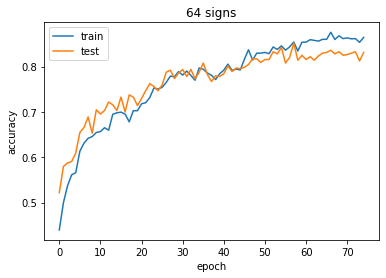

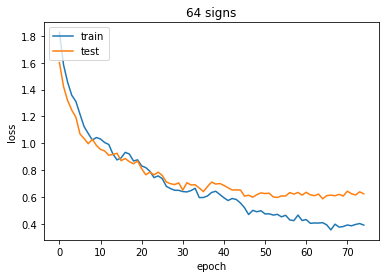

In [0]:
show_plots('64 signs')

### Evaluating

In [0]:
predictions = model.predict_classes(x_test)
rounded_labels = np.argmax(y_test, axis=1)

In [0]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.73      0.80      0.76        10
           2       0.82      0.90      0.86        10
           3       1.00      1.00      1.00        10
           4       0.75      0.60      0.67        10
           5       0.83      1.00      0.91        10
           6       1.00      0.90      0.95        10
           7       0.82      0.90      0.86        10
           8       0.90      0.90      0.90        10
           9       0.78      0.70      0.74        10
          10       0.80      0.80      0.80        10
          11       0.91      1.00      0.95        10
          12       1.00      1.00      1.00        10
          13       0.89      0.80      0.84        10
          14       1.00      0.80      0.89        10
          15       0.91      1.00      0.95        10
          16       0.83      1.00      0.91        10
          17       0.55    